# GEFS Wave Global Collection

Reads the Global GEFS Wave grib collection from NODD's S3 bucket and creates a single dataset using fsspec's ReferenceFileSystem

This notebook demonstrates how to generate the reference JSON files using Kerchunk and gribberish. It was adapted from [this notebook](https://nbviewer.org/gist/peterm790/92eb1df3d58ba41d3411f8a840be2452)

In [8]:
import fsspec
import xarray as xr

Create the virtual filesystem from which to read the NODD s3 bucket. We are going to write the resulting dataset out to our local filesystem, so we leave the write system blank

In [3]:
fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) # For now SSL false is solving my cert issues **shrug**
fs_write = fsspec.filesystem('')

Now, grab all of the files for the given model run

In [3]:
#https://noaa-gefs-pds.s3.amazonaws.com/gefs.20230706/12/wave/gridded/gefs.wave.t12z.p01.global.0p25.f012.grib2
gefs_ens_member_files = fs_read.glob('s3://noaa-gefs-pds/gefs.20230706/12/wave/gridded/gefs.wave.t12z.p01.global.0p25.*.grib2')

files = sorted(['s3://'+f for f in gefs_ens_member_files])
print(f'Read {len(files)} GEFS files')

Read 105 GEFS files


For each file, we will scan it with gribberish and extract its data to a dictionary formatted to the zarr spec. Then we will write that dictionary to a JSON file with the name formatting specified in the `make_json_name` function

In [5]:
import ujson
from gribberish.kerchunk import scan_gribberish

so = {"anon": True, "use_ssl": False}
json_dir = 'gefs_wave/'

def make_json_name(file_url, message_number): #create a unique name for each reference file
    date = file_url.split('/')[3].split('.')[1]
    name = file_url.split('/')[7].split('.')[0:7]
    return f'{json_dir}{date}_{name[0]}_{name[1]}_{name[2]}_{name[4]}_{name[3]}_{name[6]}_message{message_number}.json'

def gen_json(file_url):
    print(f'Processing {file_url}...')
    out = scan_gribberish(file_url, storage_options=so, only_vars=['htsgw'])   # create the reference using scan_grib
    for i, message in enumerate(out): # scan_grib outputs a list containing one reference per grib message
        out_file_name = make_json_name(file_url, i)  # get name
        with fs_write.open(out_file_name, "w") as f: 
            f.write(ujson.dumps(message)) # write to file

In [5]:
make_json_name('s3://noaa-gefs-pds/gefs.20230706/12/wave/gridded/gefs.wave.t12z.p01.global.0p25.f000.grib', 0)

'gefs_wave/20230706_gefs_wave_t12z_global_p01_f000_message0.json'

In [6]:
%%time
#this step is best run via a cluster
for f in files[0:5]:
    gen_json(f)

Processing s3://noaa-gefs-pds/gefs.20230706/12/wave/gridded/gefs.wave.t12z.p01.global.0p25.f000.grib2...
Processing s3://noaa-gefs-pds/gefs.20230706/12/wave/gridded/gefs.wave.t12z.p01.global.0p25.f003.grib2...
Processing s3://noaa-gefs-pds/gefs.20230706/12/wave/gridded/gefs.wave.t12z.p01.global.0p25.f006.grib2...
Processing s3://noaa-gefs-pds/gefs.20230706/12/wave/gridded/gefs.wave.t12z.p01.global.0p25.f009.grib2...
Processing s3://noaa-gefs-pds/gefs.20230706/12/wave/gridded/gefs.wave.t12z.p01.global.0p25.f012.grib2...
CPU times: user 1.27 s, sys: 545 ms, total: 1.81 s
Wall time: 5.48 s


Once generated, it can be read back in with xarray or zarr

In [7]:
import xarray as xr

# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='./gefs_wave/20230706_gefs_wave_t12z_global_p01_f000_message0.json', remote_protocol='s3', remote_options={'anon':True, 'use_ssl': False})
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False))
ds         

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[s] 2023-07-06T12:00:00
Data variables:
    htsgw      (time, latitude, longitude) float64 ...
Attributes:
    meta:     Generated with gribberishpy

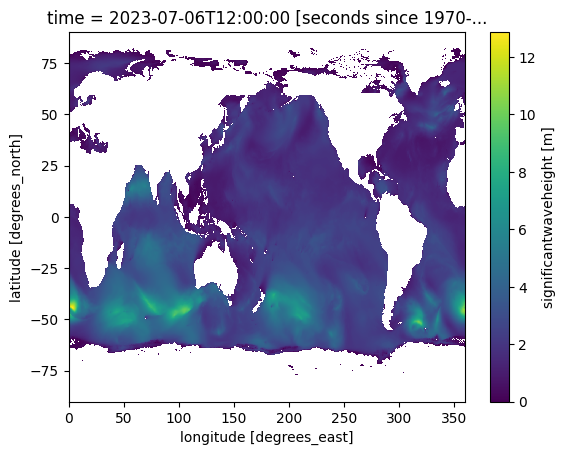

In [9]:
ds.htsgw.plot()

We can also create a single dataset from the collection of the kerchunked files 

In [11]:
from kerchunk.combine import MultiZarrToZarr
import numpy as np

reference_jsons = fs_write.ls(json_dir) #get list of file names

def fn_to_ens(index, fs, var, fn):
    import re
    import datetime
    groups = re.search(r"\_p(\d{2})", fn).groups()
    return int(groups[0])

# combine individual references into single consolidated reference
mzz = MultiZarrToZarr(reference_jsons,
                        coo_map={'ens': fn_to_ens},
                        coo_dtypes={'ens': np.dtype('int32')},
                        concat_dims = ['ens', 'time'],
                        identical_dims=['latitude', 'longitude'])
d = mzz.translate()

with open('./gefs_wave/gefswave_kerchunk.json', 'w') as f:
    f.write(ujson.dumps(d))

/Users/matthewiannucci/Developer/gribberish/python/examples/env/lib/python3.9/site-packages/kerchunk/combine.py:269: UserWarning: Concatenated coordinate 'ens' contains less than expectednumber of values across the datasets: [1]
  warnings.warn(


In [12]:
# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='./gefs_wave/gefswave_kerchunk.json', remote_protocol='s3', remote_options={'anon':True, 'use_ssl': False})
m = fs.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs=dict(consolidated=False), 
                      chunks={'time':1})

ds                      

<xarray.Dataset>
Dimensions:    (ens: 1, time: 5, latitude: 721, longitude: 1440)
Coordinates:
  * ens        (ens) int32 1
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[s] 2023-07-06T12:00:00 ... 2023-07-07
Data variables:
    htsgw      (ens, time, latitude, longitude) float64 dask.array<chunksize=(1, 1, 721, 1440), meta=np.ndarray>
Attributes:
    meta:     Generated with gribberishpy